In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
from torchsummary import summary
import time
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader

In [2]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
# Define the transformations. To begin with, we shall keep it minimum - only resizing the images and converting them to PyTorch tensors

data_transforms = transforms.Compose([
    transforms.Resize([112, 112]),
    transforms.ToTensor()
    ])

In [4]:
# Defining hyperparameters
BATCH_SIZE = 256
learning_rate = 0.001
EPOCHS = 15
numClasses=43

In [5]:

# Define path of training data

train_data_path = "C:\\Users\\HDSL53\\Desktop\\HawarITMLProjects\\With_GTSRB_datasets\\myData"
train_data = torchvision.datasets.ImageFolder(root = train_data_path, transform = data_transforms)

# Divide data into training and validation (0.8 and 0.2)
ratio = 0.8
n_train_examples = int(len(train_data) * ratio)
n_val_examples = len(train_data) - n_train_examples

train_data, val_data = data.random_split(train_data, [n_train_examples, n_val_examples])

print(f"Number of training samples = {len(train_data)}")
print(f"Number of validation samples = {len(val_data)}")

Number of training samples = 27839
Number of validation samples = 6960


In [6]:
# #categories
# import pathlib
# root=pathlib.Path(train_data_path)
# classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [7]:
# numClasses=len(classes)
# numClasses

In [8]:
train_loader=DataLoader(train_data,batch_size=64, shuffle=True)

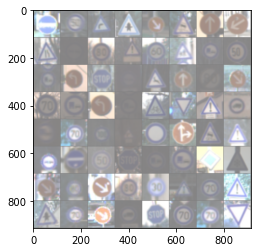

In [9]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

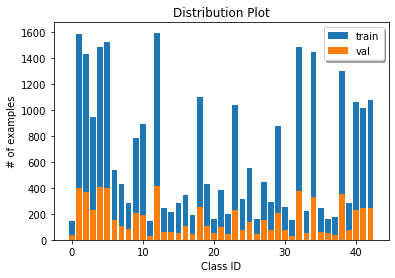

In [10]:
# Plot histogram for training and validation data
train_hist = [0]*numClasses
for i in train_data.indices:
    tar = train_data.dataset.targets[i]
    train_hist[tar] += 1
    
val_hist = [0]*numClasses
for i in val_data.indices:
    tar = val_data.dataset.targets[i]
    val_hist[tar] += 1

plt.bar(range(numClasses), train_hist, label="train")
plt.bar(range(numClasses), val_hist, label="val")
legend = plt.legend(loc='upper right', shadow=True)
plt.title("Distribution Plot")
plt.xlabel("Class ID")
plt.ylabel("# of examples")

plt.savefig("train_val_split.png", bbox_inches = 'tight', pad_inches=0.5)

In [11]:
# Create data loader for training and validation

train_loader = data.DataLoader(train_data, shuffle=True, batch_size = BATCH_SIZE)
val_loader = data.DataLoader(val_data, shuffle=True, batch_size = BATCH_SIZE)

In [12]:
# Function to count the number of parameters in the model

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [15]:
import torch.nn as nn
class AlexnetTS(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*7*7, 1000),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.5),
            nn.Linear(in_features=1000, out_features=256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256, output_dim)
            )
        
    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [13]:
numClasses

43

In [16]:
# Initialize the model
# The model is defined in the class AlexnetTS in the file class_alexnetTS.py
model = AlexnetTS(numClasses)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 15,063,891 trainable parameters


In [17]:
# Define optimizer and criterion functions
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [18]:
# If CUDA is available, convert model and loss to cuda variables

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [19]:
print(model)

AlexnetTS(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=12544, out_features=1000, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5,

In [20]:
print(summary(model, (3, 112, 112)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           1,792
         MaxPool2d-2           [-1, 64, 28, 28]               0
              ReLU-3           [-1, 64, 28, 28]               0
            Conv2d-4          [-1, 192, 28, 28]         110,784
         MaxPool2d-5          [-1, 192, 14, 14]               0
              ReLU-6          [-1, 192, 14, 14]               0
            Conv2d-7          [-1, 384, 14, 14]         663,936
              ReLU-8          [-1, 384, 14, 14]               0
            Conv2d-9          [-1, 256, 14, 14]         884,992
             ReLU-10          [-1, 256, 14, 14]               0
           Conv2d-11          [-1, 256, 14, 14]         590,080
        MaxPool2d-12            [-1, 256, 7, 7]               0
             ReLU-13            [-1, 256, 7, 7]               0
          Dropout-14                [-1

C:\Users\HDSL53\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [21]:

# Print model's state dict

print("Model's state dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
print("")

Model's state dict:
features.0.weight 	 torch.Size([64, 3, 3, 3])
features.0.bias 	 torch.Size([64])
features.3.weight 	 torch.Size([192, 64, 3, 3])
features.3.bias 	 torch.Size([192])
features.6.weight 	 torch.Size([384, 192, 3, 3])
features.6.bias 	 torch.Size([384])
features.8.weight 	 torch.Size([256, 384, 3, 3])
features.8.bias 	 torch.Size([256])
features.10.weight 	 torch.Size([256, 256, 3, 3])
features.10.bias 	 torch.Size([256])
classifier.1.weight 	 torch.Size([1000, 12544])
classifier.1.bias 	 torch.Size([1000])
classifier.4.weight 	 torch.Size([256, 1000])
classifier.4.bias 	 torch.Size([256])
classifier.6.weight 	 torch.Size([43, 256])
classifier.6.bias 	 torch.Size([43])



In [22]:
# Print optimizer details

print("Optimizer details:")
print(optimizer)
print("")

Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)



In [23]:
# Function to calculate accuracy
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [24]:
# Function to perform training of the model

def train(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    # Train the model
    model.train()
    
    for (images, labels) in loader:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        
        images = images
        labels = labels
        # Training pass
        opt.zero_grad()
        
        output, _ = model(images)
        loss = criterion(output, labels)
        
        # Backpropagation
        loss.backward()
        
        # Calculate accuracy
        acc = calculate_accuracy(output, labels)
        
        # Optimizing weights
        opt.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [25]:
# Function to perform evaluation on the trained model

def evaluate(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    # Evaluate the model
    model.eval()
    
    with torch.no_grad():
        for (images, labels) in loader:
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
                
            images = images
            labels = labels
            
            # Run predictions
            output, _ = model(images)
            loss = criterion(output, labels)
            
            # Calculate accuracy
            acc = calculate_accuracy(output, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [96]:
# Perform training

# List to save training and val loss and accuracies
train_loss_list = [0]*EPOCHS
train_acc_list = [0]*EPOCHS
val_loss_list = [0]*EPOCHS
val_acc_list = [0]*EPOCHS

for epoch in range(EPOCHS):
    print("Epoch-%d: " % (epoch))

    train_start_time = time.monotonic()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    train_end_time = time.monotonic()

    val_start_time = time.monotonic()
    val_loss, val_acc = evaluate(model, val_loader, optimizer, criterion)
    val_end_time = time.monotonic()
    
    train_loss_list[epoch] = train_loss
    train_acc_list[epoch] = train_acc
    val_loss_list[epoch] = val_loss
    val_acc_list[epoch] = val_acc
    
    print("Training: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (train_loss, train_acc, train_end_time - train_start_time))
    print("Validation: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (val_loss, val_acc, val_end_time - val_start_time))
    print("")

Epoch-0: 
Training: Loss = 3.5440, Accuracy = 0.0601, Time = 1174.33 seconds
Validation: Loss = 3.3885, Accuracy = 0.0647, Time = 81.58 seconds

Epoch-1: 
Training: Loss = 3.0504, Accuracy = 0.1479, Time = 1174.69 seconds
Validation: Loss = 2.0574, Accuracy = 0.3577, Time = 89.24 seconds

Epoch-2: 
Training: Loss = 1.6841, Accuracy = 0.4344, Time = 1256.80 seconds
Validation: Loss = 1.3062, Accuracy = 0.5578, Time = 87.91 seconds

Epoch-3: 
Training: Loss = 1.2085, Accuracy = 0.5861, Time = 1360.50 seconds
Validation: Loss = 0.8757, Accuracy = 0.7103, Time = 96.98 seconds

Epoch-4: 
Training: Loss = 0.6962, Accuracy = 0.7640, Time = 1315.28 seconds
Validation: Loss = 0.3467, Accuracy = 0.8826, Time = 87.62 seconds

Epoch-5: 
Training: Loss = 0.3311, Accuracy = 0.8897, Time = 1273.44 seconds
Validation: Loss = 0.1830, Accuracy = 0.9421, Time = 89.55 seconds

Epoch-6: 
Training: Loss = 0.1900, Accuracy = 0.9385, Time = 1326.34 seconds
Validation: Loss = 0.0906, Accuracy = 0.9734, Time = 

KeyboardInterrupt: 

In [97]:
# Define transformations

test_transforms = transforms.Compose([
    transforms.Resize([112, 112]),
    transforms.ToTensor()
    ])

In [111]:
# Define path of test data

img_dir  = "C:\\Users\\HDSL53\\Desktop\\HawarITMLProjects\\With_GTSRB_datasets\\Test"
# test_data = torchvision.datasets.ImageFolder(root = test_data_path, transform = test_transforms)
# test_loader = data.DataLoader(test_data, batch_size=1, shuffle=False)

In [115]:
test_file ="C:\\Users\\HDSL53\\Desktop\\HawarITMLProjects\\With_GTSRB_datasets\\Test.csv"
import pandas as pd

In [116]:
from torchvision.io import read_image
from torch.utils.data import Dataset
class GTSRB(Dataset):
    def __init__(self, annotations_file, img_dir , transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)[["Path","ClassId"]]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        label = self.img_labels.iloc[idx, 1]
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [117]:
from torchvision.transforms import ToTensor, Pad, Compose,CenterCrop, ToPILImage, Normalize, ConvertImageDtype, Resize


In [118]:
test_data = GTSRB(img_dir = img_dir, annotations_file = test_file,
                  transform = Compose([Resize((30,30)), ConvertImageDtype(torch.float32)]))

In [119]:
from torch.utils.data import DataLoader
test_dataloader = DataLoader(test_data)

In [123]:
model

AlexnetTS(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=12544, out_features=1000, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5,

In [124]:

# Generating labels of classes

num = range(numClasses)
labels = []
for i in num:
    labels.append(str(i))
labels = sorted(labels)
for i in num:
    labels[i] = int(labels[i])
print("List of labels : ")
print("Actual labels \t--> Class in PyTorch")
for i in num:
    print("\t%d \t--> \t%d" % (labels[i], i))

List of labels : 
Actual labels 	--> Class in PyTorch
	0 	--> 	0
	1 	--> 	1
	10 	--> 	2
	11 	--> 	3
	12 	--> 	4
	13 	--> 	5
	14 	--> 	6
	15 	--> 	7
	16 	--> 	8
	17 	--> 	9
	18 	--> 	10
	19 	--> 	11
	2 	--> 	12
	20 	--> 	13
	21 	--> 	14
	22 	--> 	15
	23 	--> 	16
	24 	--> 	17
	25 	--> 	18
	26 	--> 	19
	27 	--> 	20
	28 	--> 	21
	29 	--> 	22
	3 	--> 	23
	30 	--> 	24
	31 	--> 	25
	32 	--> 	26
	33 	--> 	27
	34 	--> 	28
	35 	--> 	29
	36 	--> 	30
	37 	--> 	31
	38 	--> 	32
	39 	--> 	33
	4 	--> 	34
	40 	--> 	35
	41 	--> 	36
	42 	--> 	37
	5 	--> 	38
	6 	--> 	39
	7 	--> 	40
	8 	--> 	41
	9 	--> 	42


In [125]:
# Read the image labels from the csv file
# Note: The labels provided are all numbers, whereas the labels assigned by PyTorch dataloader are strings

df = pd.read_csv(test_file)
numExamples = len(df)
labels_list = list(df.ClassId)

In [128]:
numExamples

12630

In [ ]:
MODEL_PATH = "C:\\Users\\HDSL53\\Desktop\\HawarITMLProjects\\With_GTSRB_datasets\\Model\\modeldata.pth"
model = AlexnetTS(numClasses)
model.load_state_dict(torch.load(MODEL_PATH))
model = model

In [27]:
#Now it is for image detections 


In [29]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import time
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import pickle
from keras.models import load_model
import os